https://www.kaggle.com/c/grasp-and-lift-eeg-detection

In [1]:
import pandas as pd
import os 
import time
import sys
import re
import matplotlib.pyplot as plt
from IPython.display import clear_output
import mne
import nbformat
from IPython.lib import kernel
from nbconvert import PythonExporter
import json
import urllib2

%matplotlib inline

#https://www.kaggle.com/c/grasp-and-lift-eeg-detection
#the *_data.csv files contain the raw 32 channels EEG data (sampling rate 500Hz)

def update_progress(progress):
    barLength = 10 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()
def convertNotebook(notebookPath, modulePath):
    with open(notebookPath) as fh:
        nb = nbformat.reads(fh.read(), nbformat.NO_CONVERT)

    exporter = PythonExporter()
    source, meta = exporter.from_notebook_node(nb)

    with open(modulePath, 'w+') as fh:
        fh.writelines(source.encode('utf-8'))

def convert_to_py():
    connection_file_path = kernel.get_connection_file()
    connection_file = os.path.basename(connection_file_path)
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]
    sessions = json.load(urllib2.urlopen('http://127.0.0.1:8888/api/sessions'))
    for sess in sessions:
        if sess['kernel']['id'] == kernel_id:
            file_out=sess['notebook']
            break
        
    file_out1=file_out["path"]

    pattern=u"/\w*.ipynb"
    ipython_name=re.findall(pattern,file_out1)[0][1:]
    
    notebookPath = ipython_name
    modulePath= notebookPath[:-6]+".py"
    convertNotebook(notebookPath,modulePath)

In [2]:
convert_to_py()

In [3]:
folder="/home/vitaly/anaconda2/vit/DATA/GAL/train"


In [12]:

class DataManipulation(object):
    
    __sfreq=500 # 500 Hz frequncy sampling
    __ch_names=['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4',
 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
      #channel names from data descr
    
    def __init__(self,folder_name):
            self.folder_name = folder_name
            allfiles=" ".join(os.listdir(self.folder_name))
            pattern=u"\d*_series\d*"
            files_data=re.findall(pattern,allfiles)
            tt=list(set(files_data))
            #'subj7_series1_events.csv', 'subj8_series3_data.csv'),
            f1=map(lambda x:"subj"+x+"_events.csv",tt)
            f2=map(lambda x:"subj"+x+"_data.csv",tt)
            data={"file_events":f1,"file_data":f2}
            bd=pd.DataFrame(data)
            self.bd=bd
            self.N=bd.shape[0]
            
    def print_files(self):
        return zip(self.files_events,self.files_data)
    def clean_data_checking(self):
        file_data_ok=[]
        file_events_ok=[]
        i=0
        print "checking data csv files..."
        for file_data in self.bd.file_data:
            
            try:
                pd.read_csv(self.folder_name+"/"+file_data)
                file_data_ok.append(1)
            except:
                print "exp"
                file_data_ok.append(0)
            time.sleep(0.01)
            #clear_output()
            update_progress(1.0*i/(self.N-1))
            i=i+1

            
        i=0    
        print "checking events csv files..."
        for file_events in self.bd.file_events:
            try:
                file_events_ok.append(1)
                pd.read_csv(self.folder_name+"/"+file_events)
            except:
                print "exp"
                file_events_ok.append(0)
            time.sleep(0.01)
            #clear_output()
            update_progress(1.0*i/(self.N-1))
            i=i+1

        self.bd["data_ok"]=file_data_ok
        self.bd["events_ok"]=file_events_ok
    def read_file(self,numero=0,log=0):
        if log==0: # reading data file
            return pd.read_csv(self.folder_name+"/"+self.bd.file_data[numero])
        else: # reading events file
            return pd.read_csv(self.folder_name+"/"+self.bd.file_events[numero])
    def read_and_norm_data(self,numero=0,fres=50,fr1=1,fr2=24):
        #numero of file to be read
        #log 0 is data 1 is events
        #fres resampling frequency
        #fr1 first freq º
        #fr2 s2 freq
        log=0
        data=self.read_file(numero,log)
        data=data.values[:,1:]
        info = mne.create_info(  ch_names=self.__ch_names,       sfreq=self.__sfreq    )
        data = mne.io.RawArray(data.T, info,verbose=False)
        
        for names in data.ch_names:
            data.set_channel_types({names:'eeg'})
        
        montage = mne.channels.read_montage('standard_1020')
        data.set_montage(montage,verbose=None)
        clear_output()
        
        
        data, _ = mne.io.set_eeg_reference(data) # again average rereference
        data.resample(fres, npad="auto",verbose=None)  # set sampling frequency to 145Hz
        data.filter(fr1,fr2,h_trans_bandwidth='auto', filter_length='auto',
               phase='zero',verbose=None)
        return data
    def read_and_norm_events(self,numero=0,fres=50,fr1=1,fr2=24):
        #numero of file to be read
        #log 0 is data 1 is events
        #fres resampling frequency
        #fr1 first freq º
        #fr2 s2 freq
        log=1
        data=self.read_file(numero,log)
        data=data.values[:,1:]
        
        info = mne.create_info(  ch_names=self.__ch_names,       sfreq=self.__sfreq    )
        data = mne.io.RawArray(data.T, info,verbose=False)
        
        for names in data.ch_names:
            data.set_channel_types({names:'eeg'})
        
        montage = mne.channels.read_montage('standard_1020')
        data.set_montage(montage,verbose=None)
        clear_output()
        
        
        data, _ = mne.io.set_eeg_reference(data) # again average rereference
        data.resample(fres, npad="auto",verbose=None)  # set sampling frequency to 145Hz
        data.filter(fr1,fr2,h_trans_bandwidth='auto', filter_length='auto',
               phase='zero',verbose=None)
        return data
    
        

d=DataManipulation(folder)
print d.N



96


In [13]:
data=d.read_and_norm()


Adding average EEG reference projection.
Multiple deprecated filter parameters were used:
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14


<ipython-input-12-1cf0b9cdf95c>:87: DeprecationWarning: Multiple deprecated filter parameters were used:
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
  phase='zero',verbose=None)


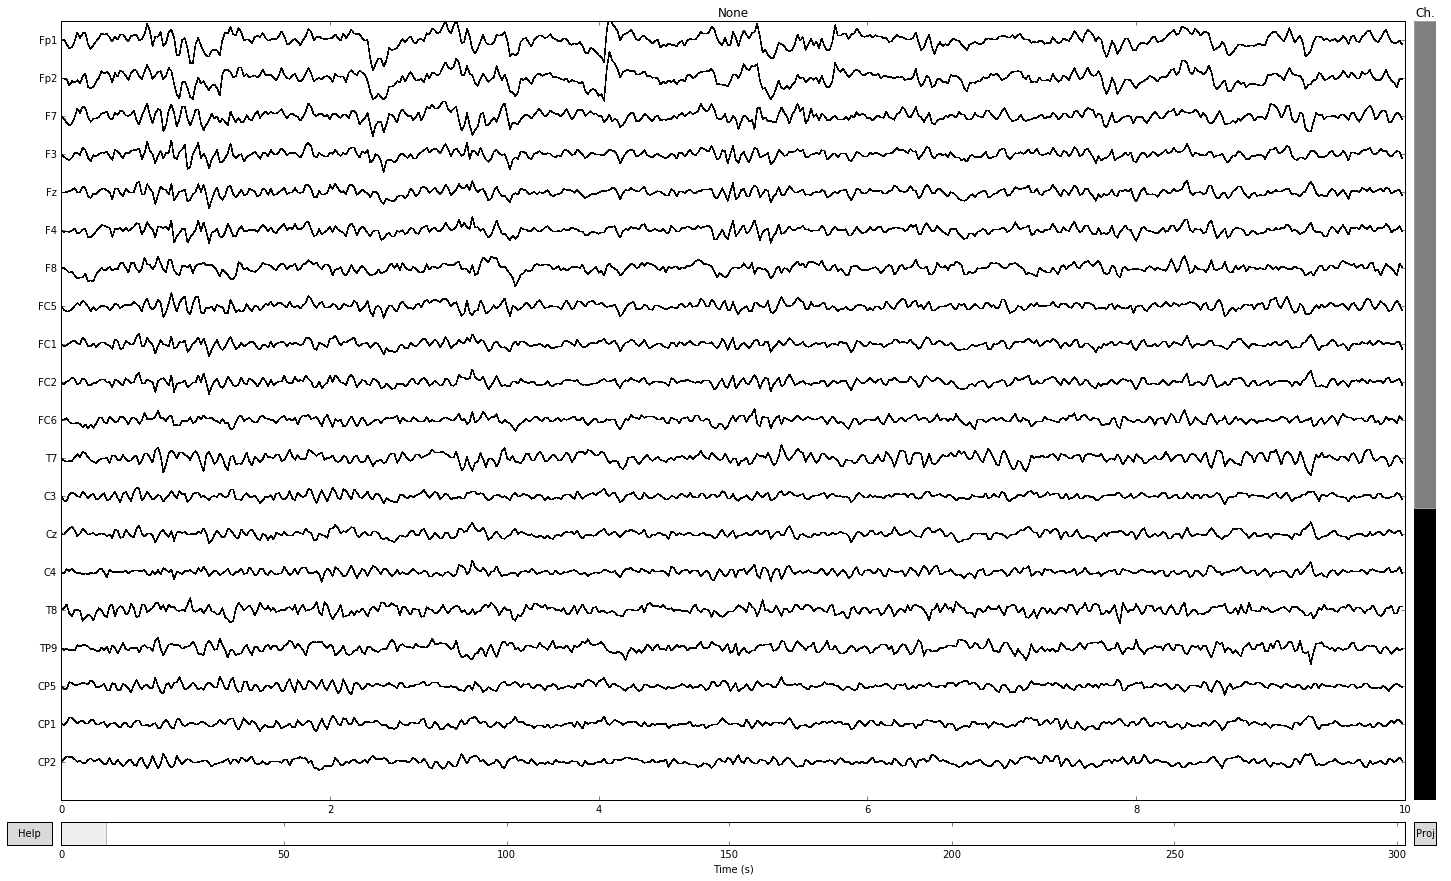

In [6]:
data.plot(scalings="auto")#, duration=80.0)
plt.show()

In [11]:
data.load_data()

<RawArray  |  None, n_channels x n_times : 32 x 15087 (301.7 sec), ~3.8 MB, data loaded>

In [8]:
d.read_file(0,1)

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj2_series7_0,0,0,0,0,0,0
1,subj2_series7_1,0,0,0,0,0,0
2,subj2_series7_2,0,0,0,0,0,0
3,subj2_series7_3,0,0,0,0,0,0
4,subj2_series7_4,0,0,0,0,0,0
5,subj2_series7_5,0,0,0,0,0,0
6,subj2_series7_6,0,0,0,0,0,0
7,subj2_series7_7,0,0,0,0,0,0
8,subj2_series7_8,0,0,0,0,0,0
9,subj2_series7_9,0,0,0,0,0,0
